## Read in the appropriate packages

In [ ]:
!pip install pmdarima -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.4 MB/s eta 0:00:00


In [ ]:
from pandas_datareader import data as pdr #read data from yahoo finance api
import matplotlib.pyplot as plt #viz #GUI manager
import seaborn as sns #viz #plotly is another package
import datetime
import pandas as pd
import numpy as np
from pandas import Grouper #groupby
#statistical data exploration, conducting statistical tests, and estimation of different statistical models
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # double and triple exponential smoothing
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
from sklearn.metrics import mean_squared_error #accuracy metrics
from math import sqrt
from sklearn.metrics import mean_absolute_error #accuracy metrics

from random import gauss #create gaussian white noise
from random import seed
from pandas import Series

from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity

from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA

import pmdarima as pm #auto arima


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. **Read in the monthly anti-diabetic drug sales in Australia dataset**

Download the data from the the gdrive: https://drive.google.com/drive/folders/1JyHJPZGgJDJL5WcLaxwmfij2bcuiF08P?usp=drive_link

In [ ]:
drug_sales_df = pd.read_csv('/content/drive/MyDrive/drug_sales_australia.csv',
                            parse_dates=['date'],
                            index_col=['date'])
print(drug_sales_df.isnull().sum())
drug_sales_df

value    0
dtype: int64


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


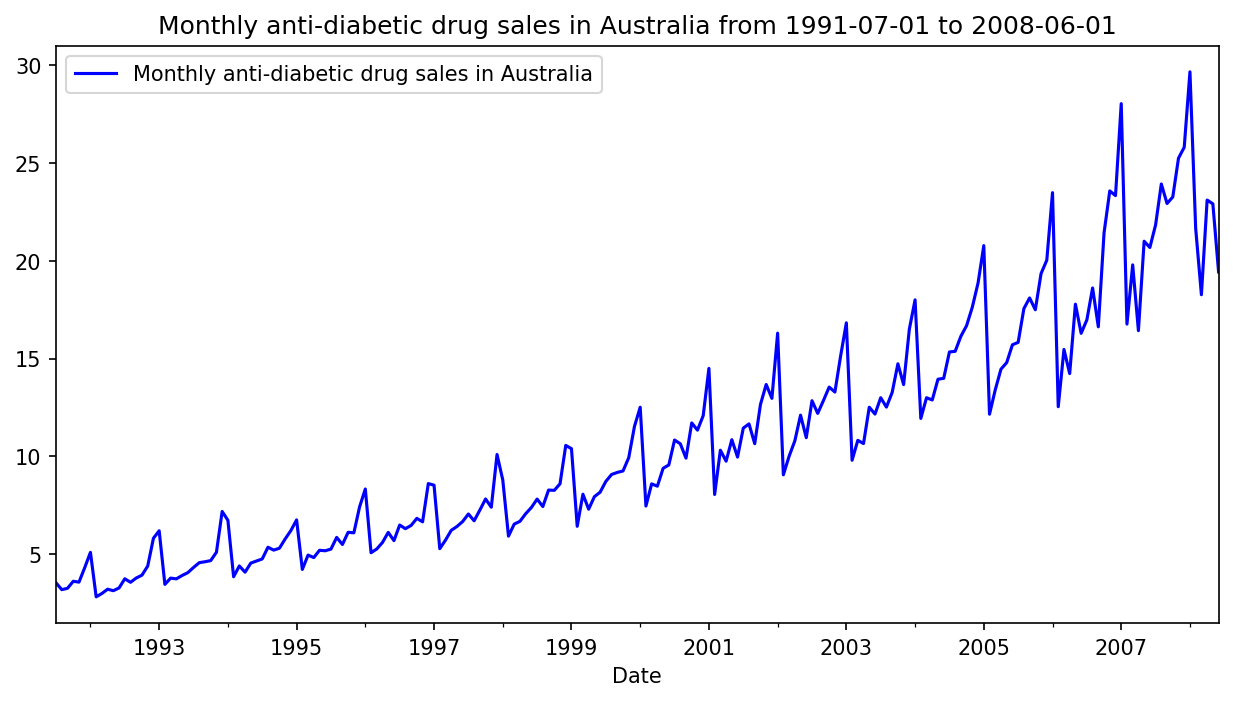

In [ ]:
# Visualizing the series

# to set the plot size
plt.figure(figsize=(10, 5), dpi=150) #dpi = resolution. default 100.

# in plot method we set the label and color of the curve.
drug_sales_df['value'].plot(label='Monthly anti-diabetic drug sales in Australia', color='blue')

# adding title to the plot
plt.title('Monthly anti-diabetic drug sales in Australia from {} to {}'.format('1991-07-01', '2008-06-01'))

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


## Stationarity  

### Why Does Stationarity Matter in Time Series Analysis? Why do we have to make sure our data set is stationary before we can run different ARIMA models on it?

Stationarity is crucial in time series analysis because it ensures that the statistical properties of a time series remain constant over time. By removing trends and seasonality, stationarity allows us to focus on the underlying dynamics and capture autocorrelation effectively. ARIMA models assume stationarity and rely on it to make reliable predictions. Ensuring stationarity before applying ARIMA models is necessary to meet model assumptions and obtain accurate results.

1. Consider the forecasting problem. How do you forecast? If everything's different tomorrow then it's impossible to forecast, because everything's going to be different. So the key to forecasting is to find something that will be the same tomorrow, and extend that to tomorrow. Hence, a stationarized series is relatively easy to predict.

2. Statistical modeling methods assume or require the time series to be stationary to be effective. The ARIMA models predict that the mean and variance will be the same in the future as they have been in the past. A stationary time series will also allow us to obtain meaningful statistics such as means, variances, and correlations with other variables. These stats are only useful descriptors if the series is stationary.

3. As in the case of the monthly anti-diabetic drug sales, the series is consistently increasing over time. Hence, the sample mean and variance will grow with the size of the sample and the models will always underestimate the mean and variance in the future periods.

Ssource: https://towardsdatascience.com/why-does-stationarity-matter-in-time-series-analysis-e2fb7be74454

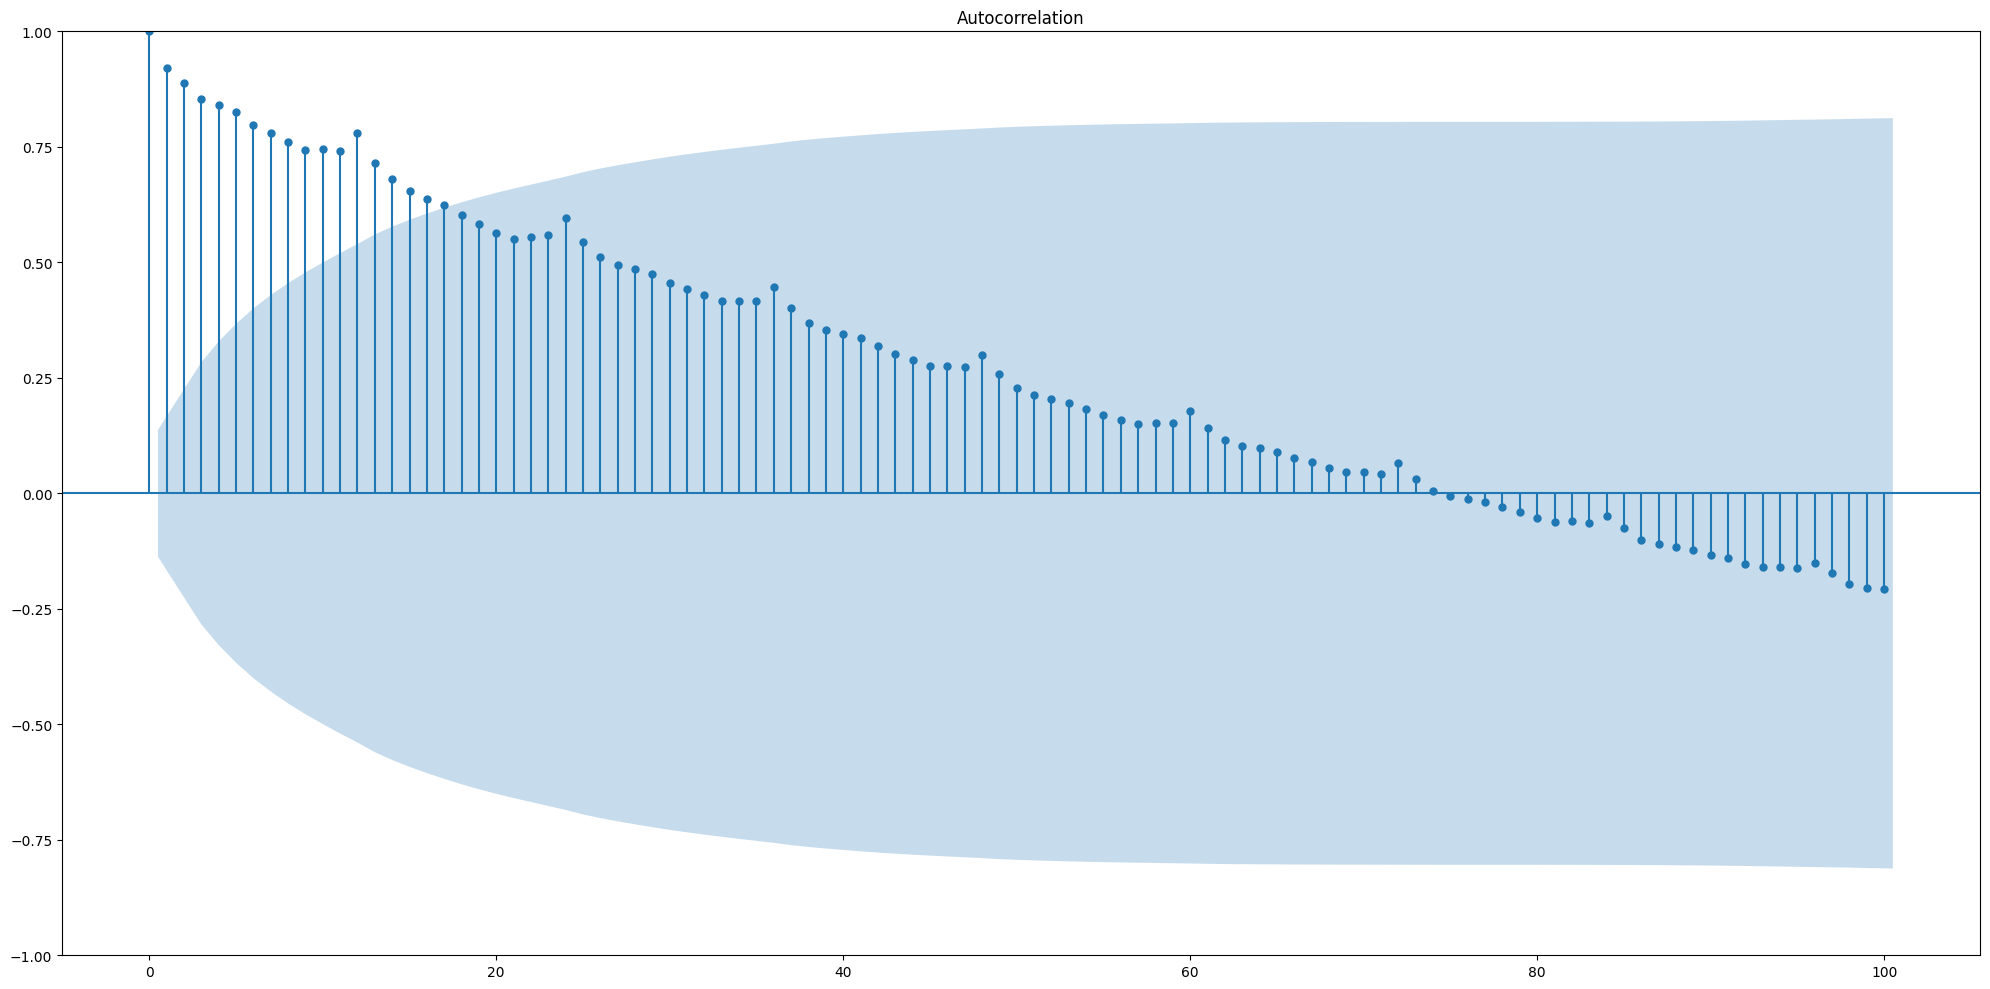

In [ ]:
#check if the data is stationary

# autocorrelation plot of the dataset
fig = plot_acf(drug_sales_df, lags=100)
fig.set_size_inches((20, 10))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [ ]:
#data has trend as well as seasonlity of 12 months

## **Unit Root Test - Augmented Dickey-Fuller (ADF) statistical test to check stationarity**

In [ ]:
# let's check it for our time series

In [ ]:
X = drug_sales_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 3.145186
p-value: 1.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


Running the test prints the test statistic value of 3.14. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset). As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of 3.14 is greater than the value of -2.87 at 5%. Also, the p-value is greater than 0.05.

This suggests that we fail to reject the null hypothesis with a significance level of 5%. Failing to reject the null hypothesis means that the process a unit root, and in turn that the time series is non-stationary.

## Differencing

One of the best ways to make a non-stationary time series stationary — compute the differences between consecutive observations. This is known as differencing.

Transformations such as logarithms can help to stabilise the variance of a time series. Differencing can help stabilise the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trend and seasonality.

<Axes: xlabel='date'>

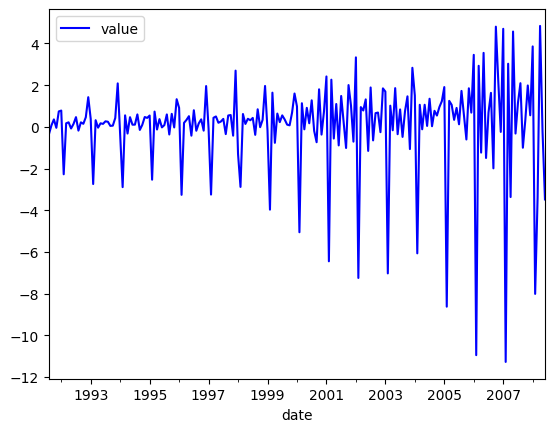

In [ ]:
#create differenced dataset
first_diff_df = drug_sales_df.diff().dropna()
first_diff_df.plot(color='blue')

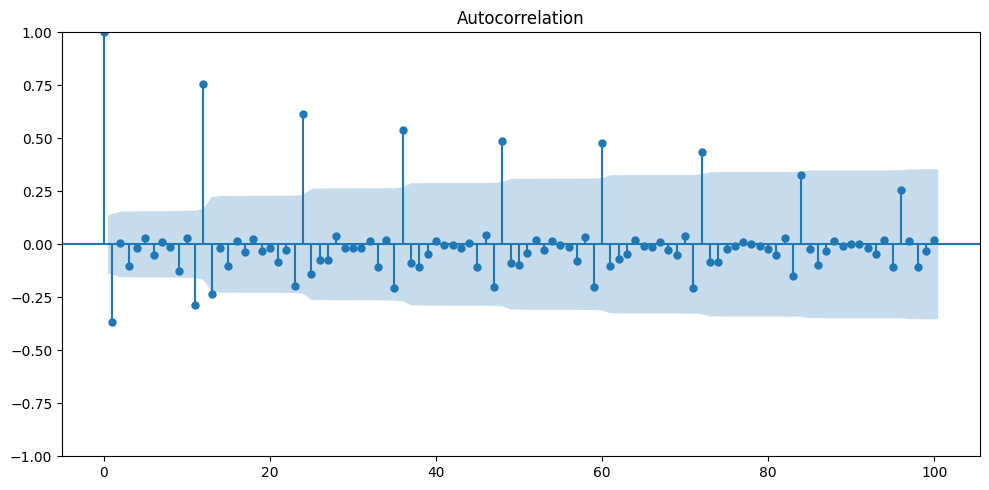

In [ ]:
# autocorrelation plot of differenced dataset
fig = plot_acf(first_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [ ]:
X = first_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.495172
p-value: 0.116653
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


From the ACF and line plot and the ADF test p-value we can deduce that the series is non-stationary. As we can see a seasonal pattern, let us apply seasonal differencing.

<Axes: xlabel='date'>

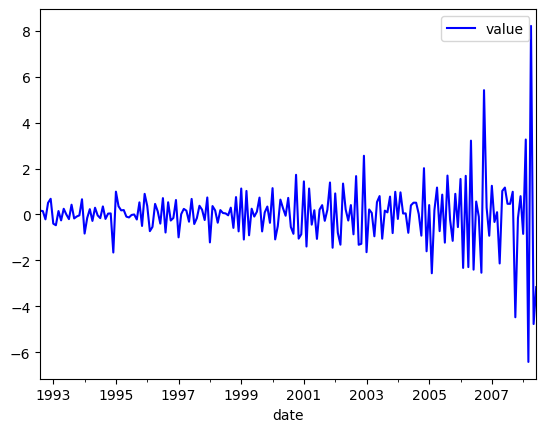

In [ ]:
seasonal_diff_df = first_diff_df.diff(12).dropna() #12 months seasonality
seasonal_diff_df.plot(color = 'blue')

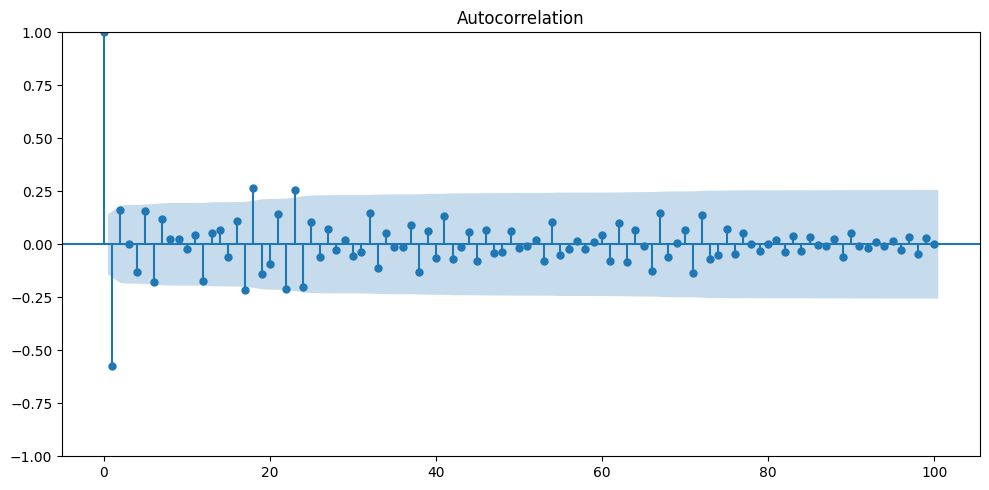

In [ ]:
# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(seasonal_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

In [ ]:
X = seasonal_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.783440
p-value: 0.000058
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


Since p-value is less than 0.05 we can reject the null hypothesis and the data is stationary.

In [ ]:
#lets see what woul've happened if we seasonally differeced first

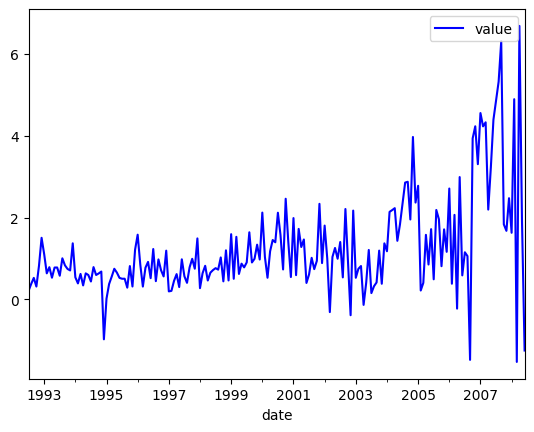

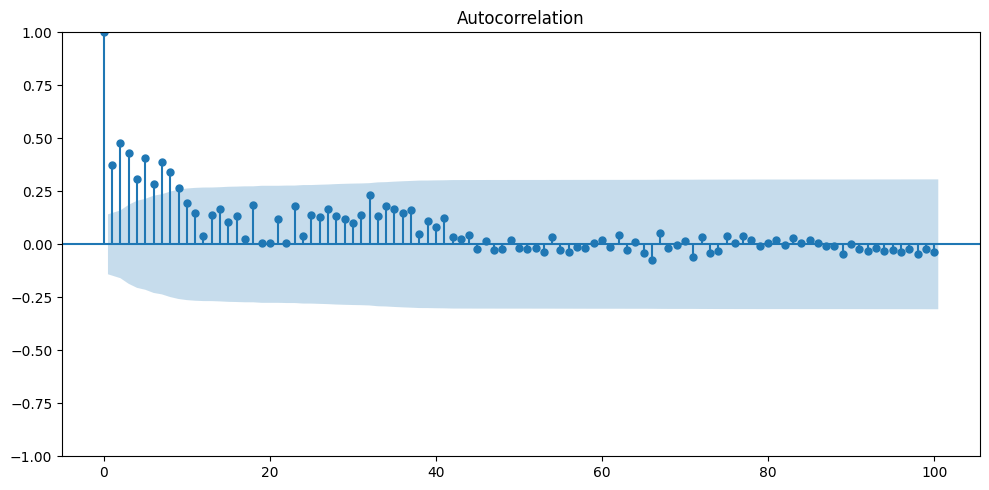

ADF Statistic: -2.092723
p-value: 0.247451
Critical Values:
	1%: -3.468
	5%: -2.878
	10%: -2.576


In [ ]:
seasnl_diff_df = drug_sales_df.diff(12).dropna()
seasnl_diff_df.plot(color='blue')

fig = plot_acf(seasnl_diff_df, lags=100)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

X = seasnl_diff_df.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

## Seasonal differencing and interpretation of differencing

When both seasonal and first differences are applied -
1. it makes no difference which is done first—the result will be the same.
2. If seasonality is strong, it is recommended that seasonal differencing be done first because sometimes the resulting series will be stationary and there will be no need for further first difference.

Also, it is important that if differencing is used, the differences are interpretable.
1. first differences are the change between one observation and the next.
2. seasonal differences are the change between one year to the next.

But taking lag 3 differences for yearly data, for example, results in a model which cannot be sensibly interpreted.


## **Time to test out the forecasts - split data into train and test sets**

In [ ]:
drug_sales_df

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(drug_sales_df, test_size=12, random_state=25, shuffle = False)
#shuffle = False is very important to ensure the order of the data

print(f"No. of training examples: {train_data.shape[0]}")
print(f"No. of testing examples: {test_data.shape[0]}")

No. of training examples: 192
No. of testing examples: 12


In [ ]:
train_data

,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2007-02-01,16.763869
2007-03-01,19.792754
2007-04-01,16.427305


In [ ]:
test_data

,value
date,
2007-07-01,21.834890
2007-08-01,23.930204
2007-09-01,22.930357
2007-10-01,23.263340
2007-11-01,25.250030
2007-12-01,25.806090
2008-01-01,29.665356
2008-02-01,21.654285
2008-03-01,18.264945


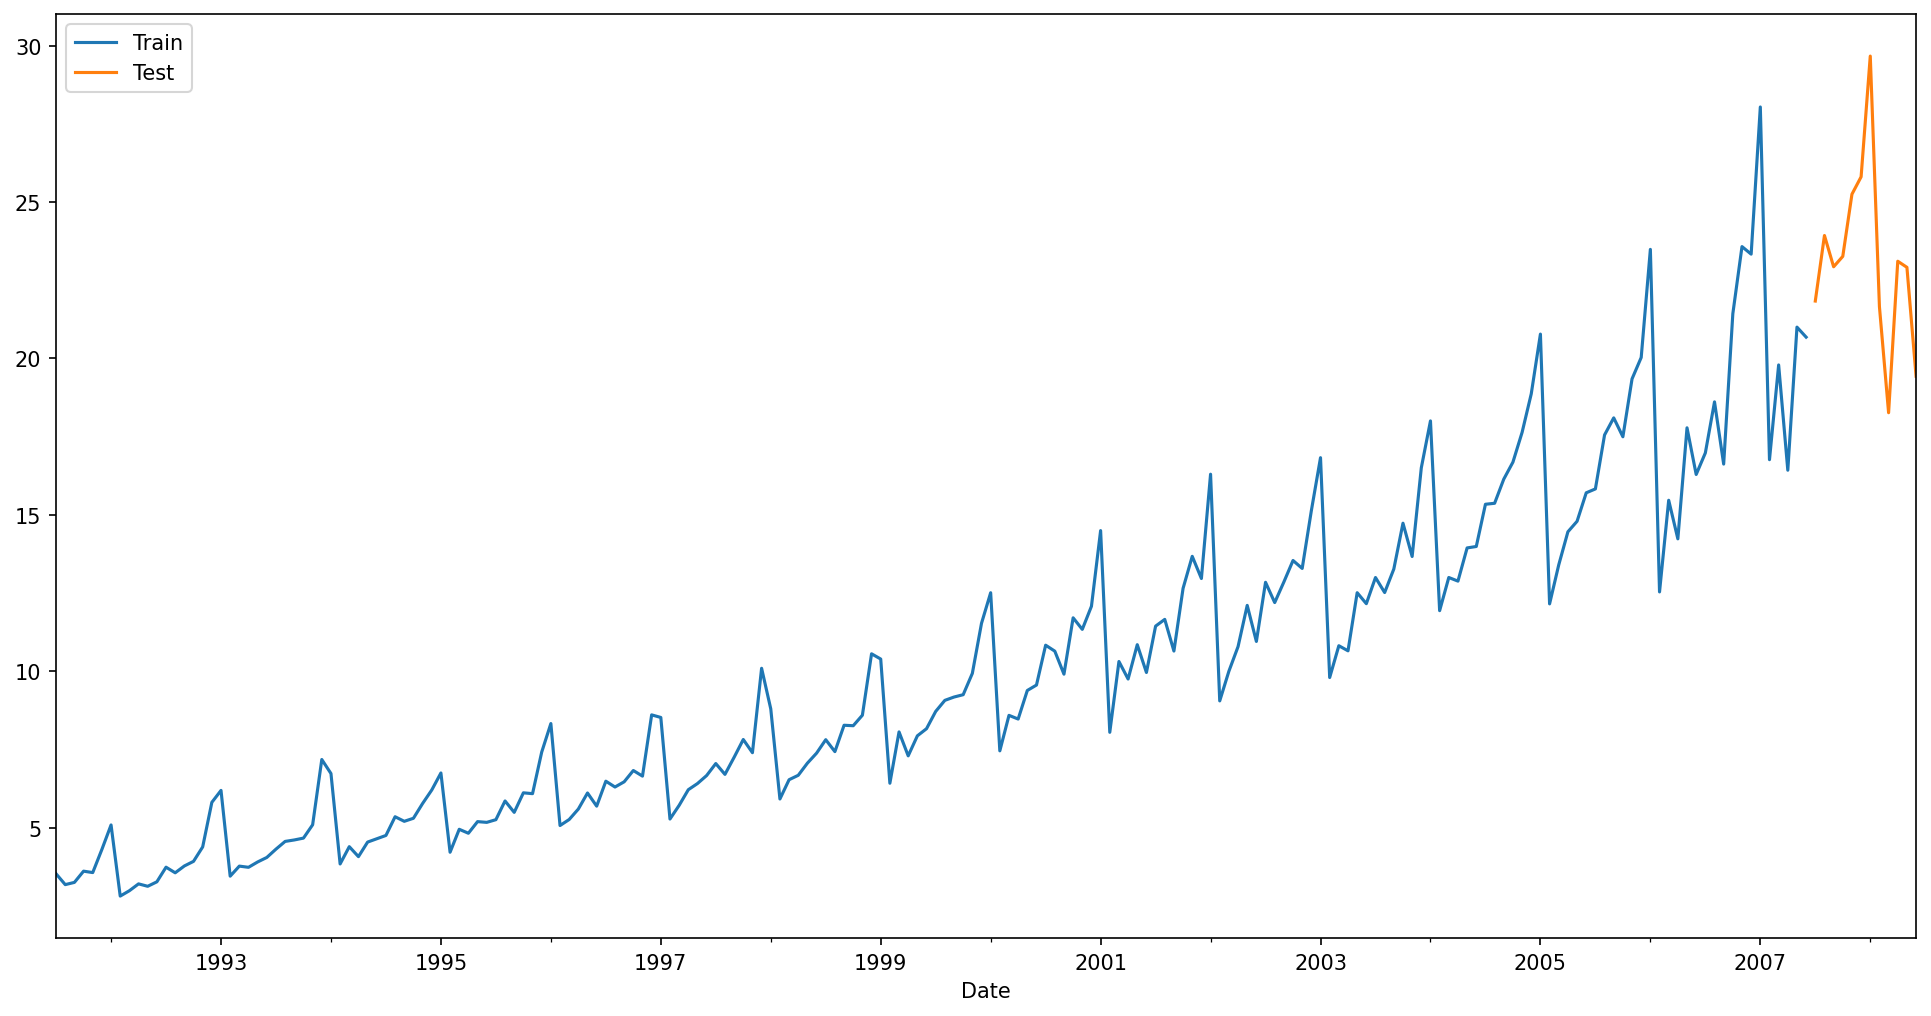

In [ ]:
#Plot train and test data

# to set the plot size
plt.figure(figsize=(16, 8), dpi=150)

# using plot method to plot close prices.
# in plot method we set the label and color of the curve.
train_data['value'].plot(label='Train')
test_data['value'].plot(label='Test')

# adding Label to the x-axis
plt.xlabel('Date')

# adding legend to the curve
plt.legend()


## Fitting Models - AR, MA, non-seasonal, and seasonal ARIMA Models

ARIMA models cater to a suite of standard structures in time series data, and as such provide a simple yet powerful method for making skillful time series forecasts.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average.

1. AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
2. I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
3. MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Each of these components are explicitly specified in the model as a parameter. A standard notation is used of ARIMA(p,d,q) where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used.

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order.
d: The number of times that the raw observations are differenced, also called the degree of differencing.
q: The size of the moving average window, also called the order of moving average.

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

Source:
1. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

### How to find the order of the AR (p) and MA (q) term?

You can find out the required number of AR and MA terms by inspecting the Autocorrelation (ACF) and Partial Autocorrelation (PACF) plot of the differenced time series.

What is Partial Autocorrelation?

Recall that an ACF plot shows the autocorrelations which measure the relationship between lagged values of a time series. Now if yt and yt−1 are correlated, then yt−1 and yt-2 must also be correlated. However, then yt and yt-2 might be correlated, simply because they are both connected to yt-1, rather than because of any new information contained in yt-2 that could be used in forecasting yt.

To overcome this problem, we can use partial autocorrelations. These measure the relationship between yt and  yt-k after removing the effects of lags 1,2,3,...,k-1.

ACF and PACF plots of the differenced time series helps us determine if we should use AR, MA, or both components.  

ACF plot - MA(q)
1. If the stationarized time series has positive autocorrealtion at lag 1, AR terms are best. If it has negative autocorrealtion at lag 1, MA terms are best.
2. Decay and cut off of the ACF gives us hints at what terms to use.

PACF plot - AR(p)
1. If the partial autocorrelation abruptly drops off at lag k, it indicates an AR model.
2. If it drops off gradually, it suggests an MA model.


In [ ]:
# AR or MA?

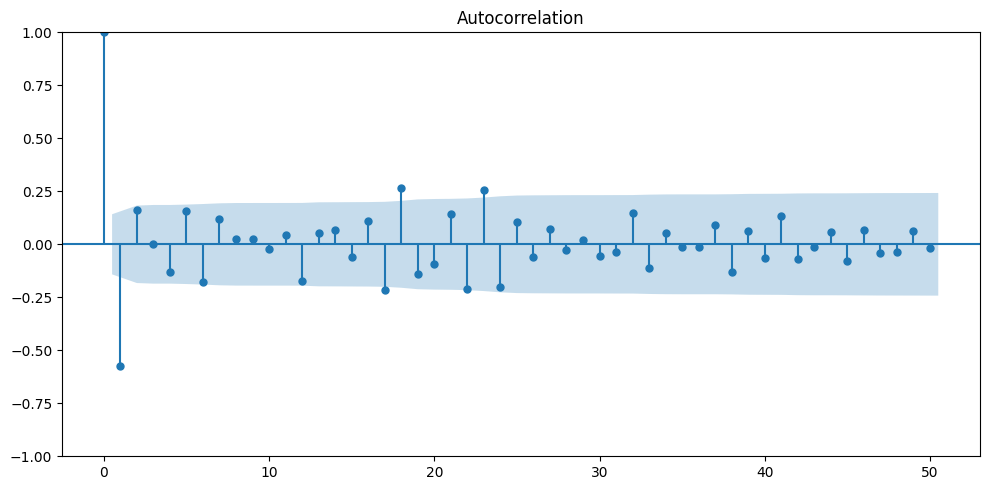

In [ ]:
# autocorrelation plot of the seasonaly differenced dataset
fig = plot_acf(seasonal_diff_df, lags=50)
fig.set_size_inches((10, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

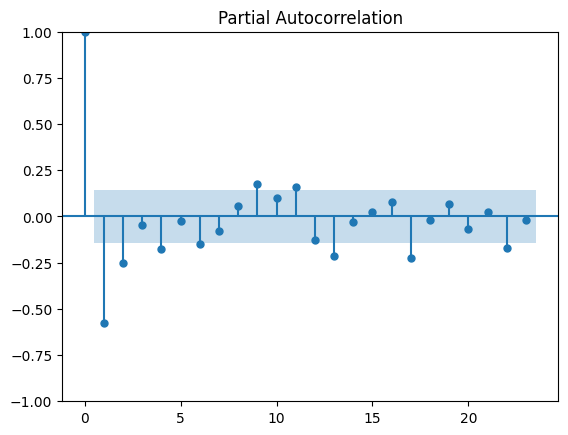

In [ ]:
#plot PACF of the differenced time series.
plot_pacf(seasonal_diff_df)
plt.show()

In [ ]:
# AR or MA?

## **Manual ARIMA no season**

In [ ]:
#define metrics dataframe which will be used below for
metrics_dataframe = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'MAPE'])


def metrics_cal(actuals, predictions, model):
    mse = mean_squared_error(actuals, predictions)
    rmse = sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

    df = pd.DataFrame({'Model': model,
                       'RMSE': rmse,
                       'MAE': mae,
                       'MAPE': mape}, index=[0])
    dataframe = metrics_dataframe.append(df)
    return dataframe

In [ ]:
model1 = sm.tsa.ARIMA(train_data, order=(2,1,1))
model1 = model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  192
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -388.544
Date:                Fri, 17 Nov 2023   AIC                            785.088
Time:                        04:54:41   BIC                            798.097
Sample:                    07-01-1991   HQIC                           790.358
                         - 06-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2753      0.126      2.191      0.028       0.029       0.522
ar.L2          0.0996      0.103      0.966      0.334      -0.102       0.302
ma.L1         -0.8552      0.078    -11.024      0.0

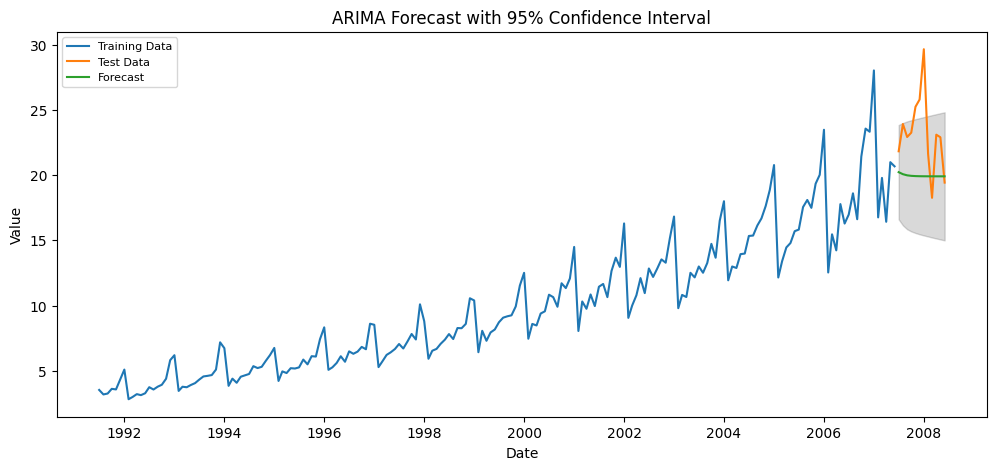

In [ ]:
# Forecast
forecast_steps = 12
forecast_values = model1.forecast(steps=forecast_steps)

# Calculate the standard errors of the forecasts
stderr = model1.get_prediction(start=len(train_data), end=len(train_data) + forecast_steps - 1).se_mean

# Calculate lower and upper bounds for a 95% confidence interval
alpha = 0.05
z_score = 1.96  # for a 95% confidence interval
lower_bound = forecast_values - z_score * stderr
upper_bound = forecast_values + z_score * stderr

# Create pandas Series for forecasts and intervals
fc_series = pd.Series(forecast_values, index=test_data.index)
lower_series = pd.Series(lower_bound, index=test_data.index)
upper_series = pd.Series(upper_bound, index=test_data.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
model2 = sm.tsa.ARIMA(train_data, order=(1,1,2))
model2 = model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  192
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -388.996
Date:                Fri, 17 Nov 2023   AIC                            785.992
Time:                        06:53:51   BIC                            799.001
Sample:                    07-01-1991   HQIC                           791.261
                         - 06-01-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4377      0.405      1.082      0.279      -0.355       1.231
ma.L1         -1.0007      0.449     -2.227      0.026      -1.881      -0.120
ma.L2          0.1295      0.344      0.376      0.7

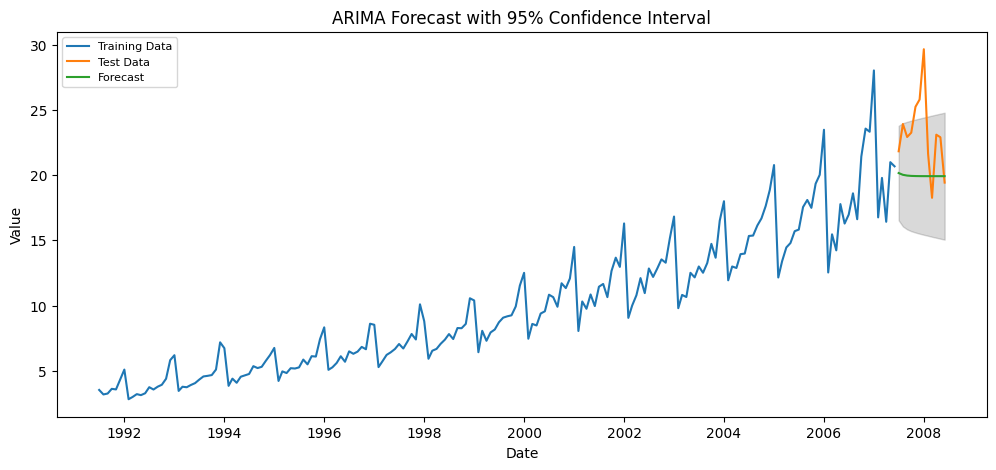

In [ ]:
# Forecast
forecast_steps = 12
forecast_values = model2.forecast(steps=forecast_steps)

# Calculate the standard errors of the forecasts
stderr = model2.get_prediction(start=len(train_data), end=len(train_data) + forecast_steps - 1).se_mean

# Calculate lower and upper bounds for a 95% confidence interval
alpha = 0.05
z_score = 1.96  # for a 95% confidence interval
lower_bound = forecast_values - z_score * stderr
upper_bound = forecast_values + z_score * stderr

# Create pandas Series for forecasts and intervals
fc_series = pd.Series(forecast_values, index=test_data.index)
lower_series = pd.Series(lower_bound, index=test_data.index)
upper_series = pd.Series(upper_bound, index=test_data.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('ARIMA Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## **Add Season to ARIMA**

In [ ]:
model3 = sm.tsa.ARIMA(train_data, order=(1,1,1), seasonal_order = (1,1,1,12))
model3 = model3.fit()
print(model3.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            value   No. Observations:                  192
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -206.600
Date:                          Fri, 17 Nov 2023   AIC                            423.200
Time:                                  05:05:59   BIC                            439.137
Sample:                              07-01-1991   HQIC                           429.663
                                   - 06-01-2007                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1855      0.060     -3.069      0.002      -0.304      -0.067
ma.L1         -0.6016      0.058    -10.392      0.

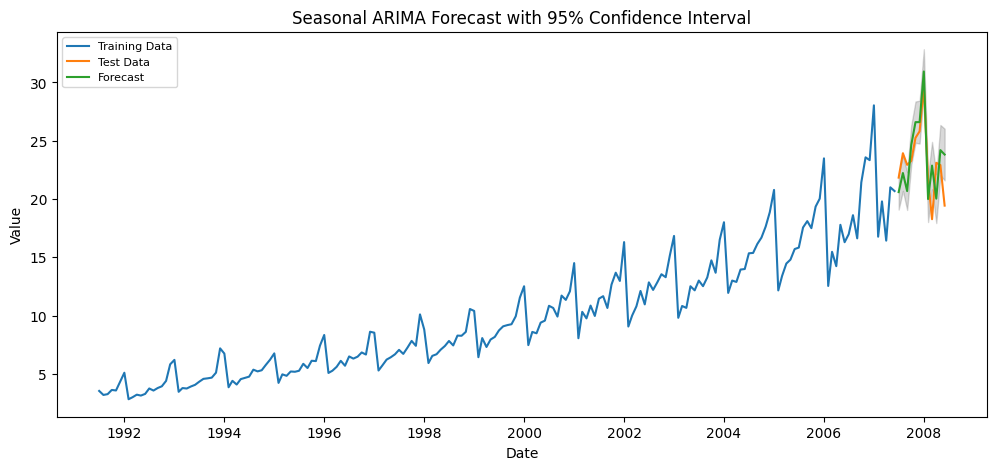

In [ ]:
# Forecast
forecast_steps = 12
forecast_values = model3.forecast(steps=forecast_steps)

# Calculate the standard errors of the forecasts
stderr = model3.get_prediction(start=len(train_data), end=len(train_data) + forecast_steps - 1).se_mean

# Calculate lower and upper bounds for a 95% confidence interval
alpha = 0.05
z_score = 1.96  # for a 95% confidence interval
lower_bound = forecast_values - z_score * stderr
upper_bound = forecast_values + z_score * stderr

# Create pandas Series for forecasts and intervals
fc_series = pd.Series(forecast_values, index=test_data.index)
lower_series = pd.Series(lower_bound, index=test_data.index)
upper_series = pd.Series(upper_bound, index=test_data.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Seasonal ARIMA Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## **Auto ARIMA Seasonal**

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(train_data, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=422.169, Time=0.90 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=505.309, Time=0.10 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=440.957, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=422.766, Time=0.58 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=423.219, Time=0.40 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=423.200, Time=2.50 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=421.304, Time=4.23 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=420.235, Time=6.16 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=422.207, Time=5.86 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=420.588, Time=7.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=420.770, Time=3.99 sec
 ARIMA(1,1,0)(1,1,2)[12]             : AIC=435.856, Time=1.65 sec
 ARIMA(2,1,1)(1,1,2)[12]             : AIC=420.069, Time=2.97 sec
 ARIMA(2,1,1)(0,1,2)[12]             : AIC=420.743, Time=1.95 sec
 ARIMA(2,1,1)(1,1,1)[12]         

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  192
Model:             SARIMAX(3, 1, 2)x(1, 1, 2, 12)   Log Likelihood                -199.854
Date:                            Fri, 17 Nov 2023   AIC                            417.708
Time:                                    01:20:45   BIC                            446.395
Sample:                                07-01-1991   HQIC                           429.341
                                     - 06-01-2007                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5684      0.199     -2.853      0.004      -0.959      -0.178
ar.L2          0.3585      0.130      2.760      0.006       0.104       0.613
ar.L3          0.3405      0.077      4.416      0.000       0.189       0.492
ma.L1         -0.2248      0.231     -0.974      0.330      -0.677       0.227
ma.L2         -0.6160      0.171     -3.609      0.000      -0.951      -0.281
ar.S.L12      -0.5863      0.357     -1.643      0.100      -1.286       0.113
ma.S.L12       0.4531      0.353      1.284      0.199      -0.239       1.145
ma.S.L24      -0.2938      0.103     -2.852      0.004      -0.496      -0.092
sigma2         0.5347      0.042     12.711      0.000       0.452       0.617
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               161.13
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               8.91   Skew:                             0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

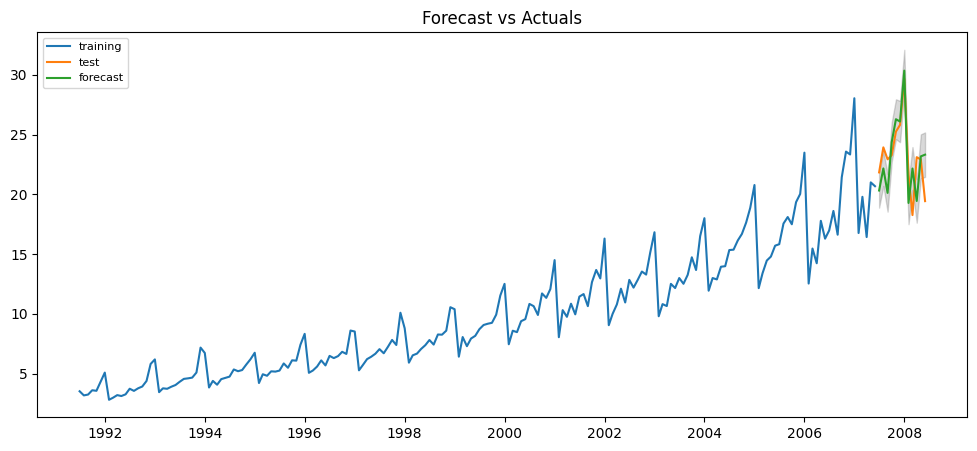

In [ ]:
# Forecast
n_periods = 12
fc_auto_seasonal, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
# make series for plotting purpose
fc_series_auto_seasonal = pd.Series(fc_auto_seasonal, index=test_data.index)
lower_series = pd.Series(confint[:, 0], index=test_data.index)
upper_series = pd.Series(confint[:, 1], index=test_data.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, label='test')
plt.plot(fc_series_auto_seasonal, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### **ARIMA backtesting**

In [ ]:
# !pip install skforecast -q
# from skforecast.model_selection import backtesting_forecaster


In [ ]:
#Back test 12 month forecasts over 4 test periods - July 2004-June 2005, July 2005-June 2006,
#July 2006-June 2007, July 2007-June 2008
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def ARIMA_BackTest(model, df, order_list,test_list=[('2004-07-01', '2005-06-01'), ('2005-07-01', '2006-06-01'),
                                                    ('2006-07-01', '2007-06-01'), ('2007-07-01', '2008-06-01')]):
  metrics_all_models = pd.DataFrame(columns = ['RMSE', 'MAE', 'MAPE'])
  forecast_results = []
  for order in order_list:
    metrics = []

    forecast =[]
    for periods in test_list:
      start, end = periods # backtest periods
      ts_train = df.loc[:start][:-1] #remove last month
      ts_test = df.loc[start:end]

      if len(order)>=3:
        model_name= order[2]
        model = sm.tsa.ARIMA(ts_train, order = order[0], seasonal_order=order[1]) #seasonal ARIMA
      else:
        model_name = order[1]
        model = sm.tsa.ARIMA(ts_train, order = order[0]) #ARIMA
      model_fit = model.fit()
      predictions = model_fit.forecast(steps=12)
      forecast.extend(predictions.values.flatten())

      metric = metrics_cal(ts_test.values.flatten(), predictions.values.flatten(), model_name)
      # print(metric)
      metrics.append(metric.values[0])

    metrics = pd.DataFrame(metrics, columns = ['MODEL','RMSE', 'MAE', 'MAPE'])
    metrics = metrics.groupby('MODEL').mean() #take mean metrics for 4 backtest periods
    # print(metrics)
    metrics_all_models=pd.concat([metrics_all_models,metrics], axis=0)
    forecast_results.append(forecast)

  return metrics_all_models, forecast_results


order_list = [[(1,1,2), 'ARIMA_1'],
              [(1,1,2), (1,1,1,12), 'SARIMA_1'],
              [(2,1,1), (1,1,1,12), 'SARIMA_2'],
              [(2,1,1), (1,1,2,12), 'SARIMA_3'],
              [(3,1,1), (1,1,1,12), 'SARIMA_4'],
              [(3,1,2), (1,1,2,12), 'SARIMA_AUTO']]
arima_backtest_result, arima_forecast_results = ARIMA_BackTest(smodel, drug_sales_df, order_list)
arima_backtest_result.sort_values(by='MAE')

,RMSE,MAE,MAPE
SARIMA_2,1.695184,1.478737,7.672968
SARIMA_3,1.695277,1.481465,7.655728
SARIMA_4,1.719780,1.484232,7.695293
SARIMA_AUTO,1.717781,1.486812,7.669726
SARIMA_1,1.732176,1.524059,7.863357
ARIMA_1,3.927992,3.087745,14.822366


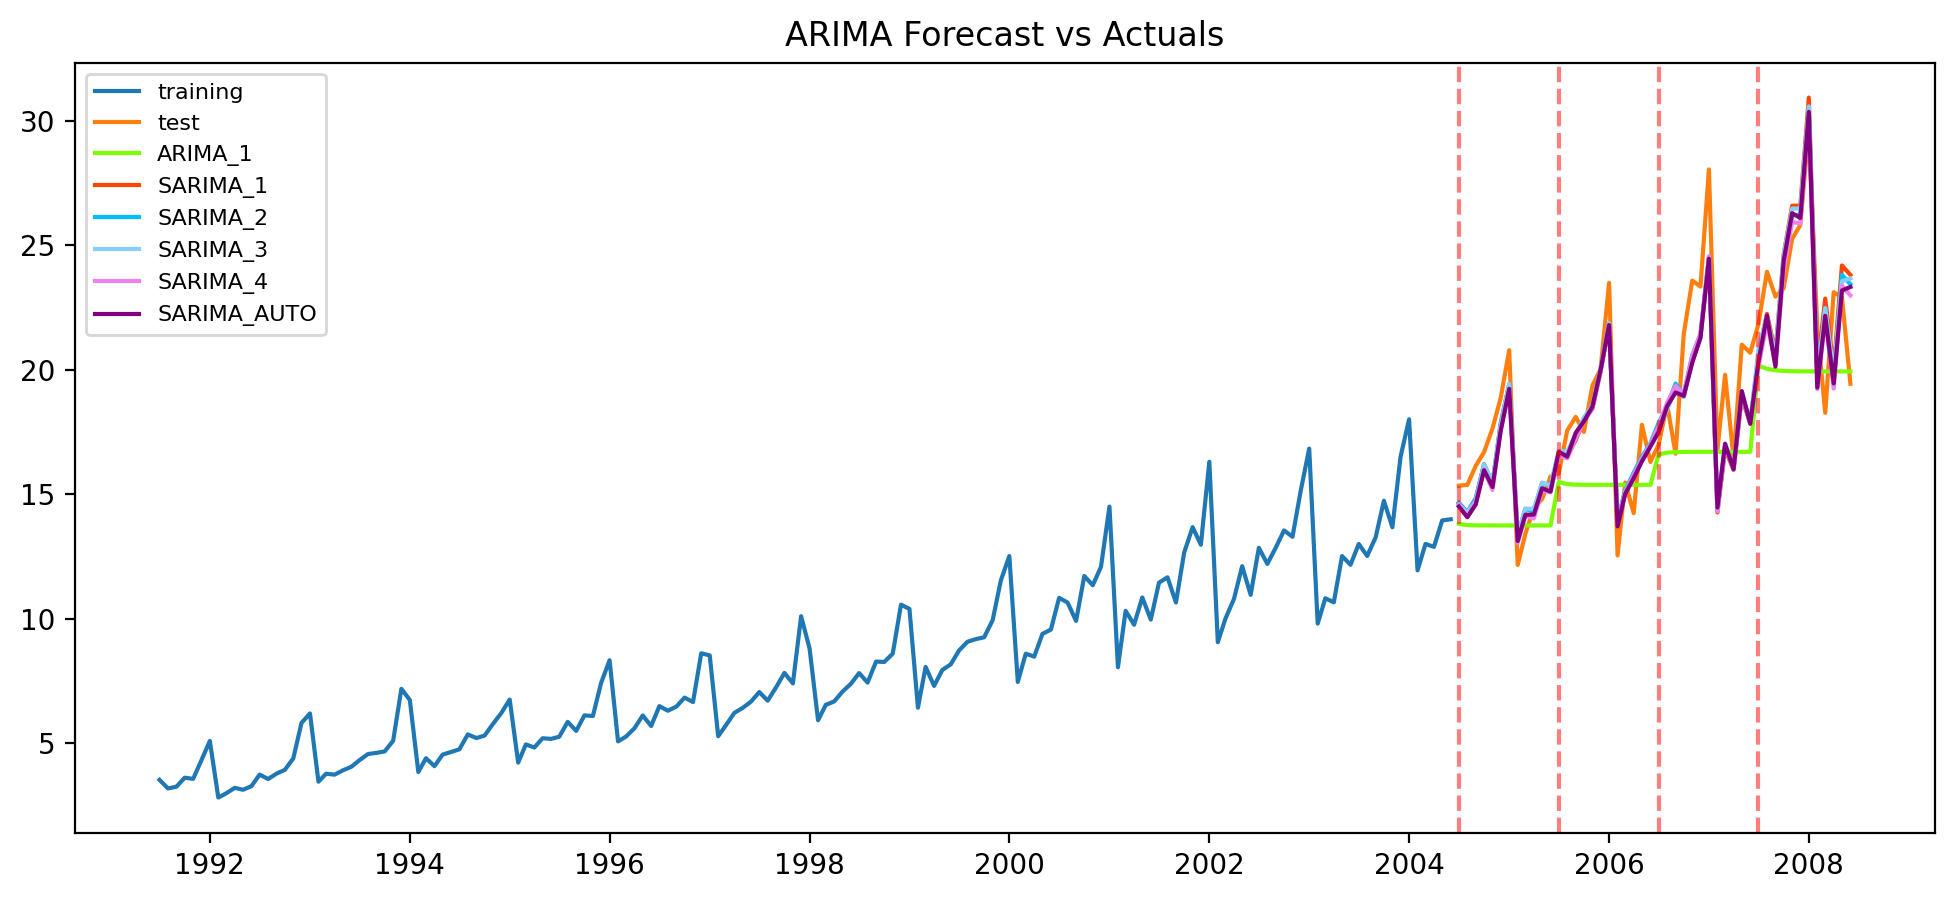

In [ ]:

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(drug_sales_df.loc[:'2004-06-01'], label='training')
plt.plot(drug_sales_df.loc['2004-07-01':'2008-06-01'], label='test')

test_index = drug_sales_df.loc['2004-07-01':'2008-06-01'].index
color_list = ['lawngreen', 'orangered', 'deepskyblue', 'lightskyblue', 'violet', 'purple']
for i, forecast in enumerate(arima_forecast_results):
  model_name = arima_backtest_result.index[i]
  fc_series = pd.Series(forecast, index=test_index)

  plt.plot(fc_series, label=model_name, color = color_list[i])

plt.title('ARIMA Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.axvline(x = pd.to_datetime('2004-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.axvline(x = pd.to_datetime('2005-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.axvline(x = pd.to_datetime('2006-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.axvline(x = pd.to_datetime('2007-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.show()



## **ETS model backtesting**

In [ ]:
def ETS_BackTest(model, df, order_list,test_list=[('2004-07-01', '2005-06-01'), ('2005-07-01', '2006-06-01'),
                                                    ('2006-07-01', '2007-06-01'), ('2007-07-01', '2008-06-01')]):
  metrics_all_models = pd.DataFrame(columns = ['RMSE', 'MAE', 'MAPE'])
  forecast_results = []
  for order in order_list:
    metrics = []

    forecast =[]
    for periods in test_list:
      start, end = periods # backtest periods
      ts_train = df.loc[:start][:-1] #remove last month
      ts_test = df.loc[start:end]

      if order[0]=='1':
        model_name = "ETS_1_" + str(order[1])
        model = SimpleExpSmoothing(train_data).fit(smoothing_level=order[1],optimized=False)
      elif order[0]=='2':
        model_name = "ETS_2_" + order[1]
        model = ExponentialSmoothing(train_data, trend = order[1]).fit()

      else:
        model_name = "ETS_3_" + order[1]
        model = ExponentialSmoothing(ts_train, trend =order[1], seasonal =order[1], seasonal_periods=12).fit()
      # print(model_name)
      predictions = model.forecast(12)
      forecast.extend(predictions.values.flatten())

      metric = metrics_cal(ts_test.values.flatten(), predictions.values.flatten(), model_name)
      # print(metric)
      metrics.append(metric.values[0])

    metrics = pd.DataFrame(metrics, columns = ['MODEL','RMSE', 'MAE', 'MAPE'])
    metrics = metrics.groupby('MODEL').mean() #take mean metrics for 4 backtest periods
    # print(metrics)
    metrics_all_models=pd.concat([metrics_all_models,metrics], axis=0)
    forecast_results.append(forecast)

  return metrics_all_models, forecast_results


order_list = [['1', 0.5], ['1', 0.9], ['2', 'add'], ['2', 'mul'], ['3', 'add'], ['3', 'mul']]
ets_backtest_result, ets_forecast_results = ETS_BackTest(smodel, drug_sales_df, order_list)
ets_backtest_result.sort_values(by='MAE')

,RMSE,MAE,MAPE
ETS_3_mul,1.393005,1.191758,6.158462
ETS_3_add,1.692975,1.487367,7.625825
ETS_1_0.5,4.059410,3.476356,19.676240
ETS_1_0.9,4.178206,3.595750,20.732872
ETS_2_add,4.439770,3.865542,22.643885
ETS_2_mul,4.811508,4.225724,25.200114


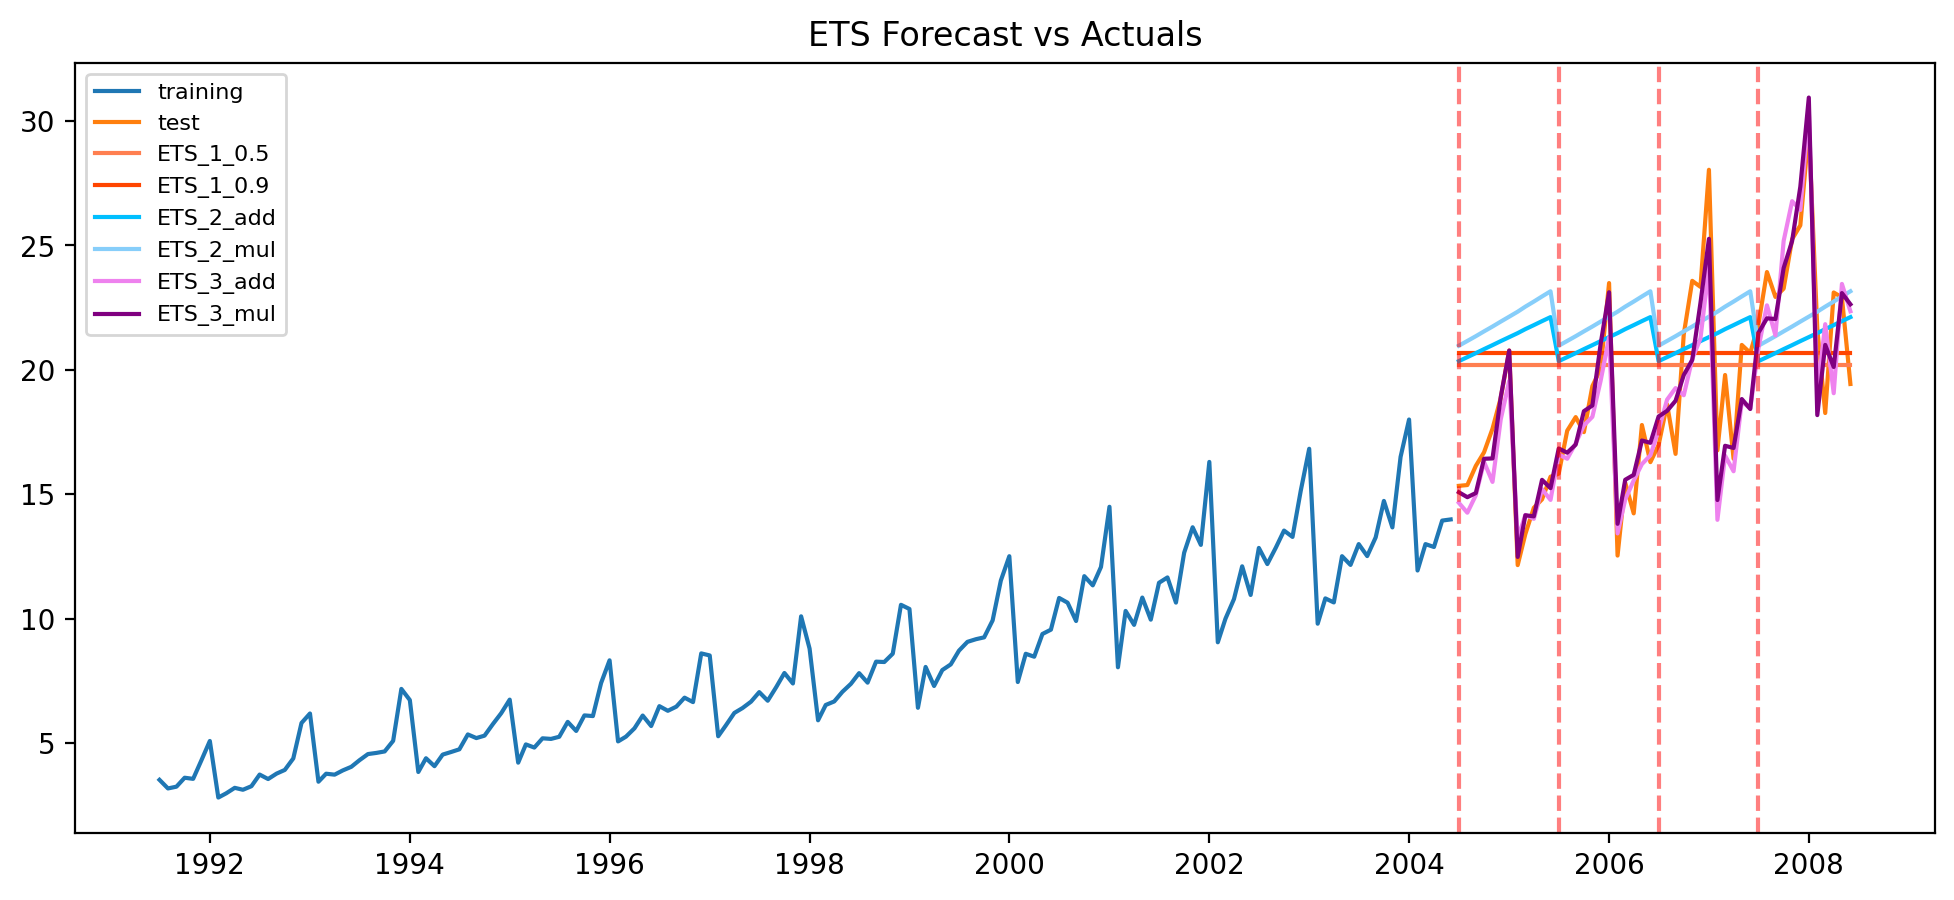

In [ ]:

# ETS Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(drug_sales_df.loc[:'2004-06-01'], label='training')
plt.plot(drug_sales_df.loc['2004-07-01':'2008-06-01'], label='test')

test_index = drug_sales_df.loc['2004-07-01':'2008-06-01'].index
color_list = ['coral', 'orangered', 'deepskyblue', 'lightskyblue', 'violet', 'purple']
for i, forecast in enumerate(ets_forecast_results):
  model_name = ets_backtest_result.index[i]
  fc_series = pd.Series(forecast, index=test_index)
  plt.plot(fc_series, label=model_name, color = color_list[i])

plt.title('ETS Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.axvline(x = pd.to_datetime('2004-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.axvline(x = pd.to_datetime('2005-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.axvline(x = pd.to_datetime('2006-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.axvline(x = pd.to_datetime('2007-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.show()



## **Best ARIMA and best ETS visualization**

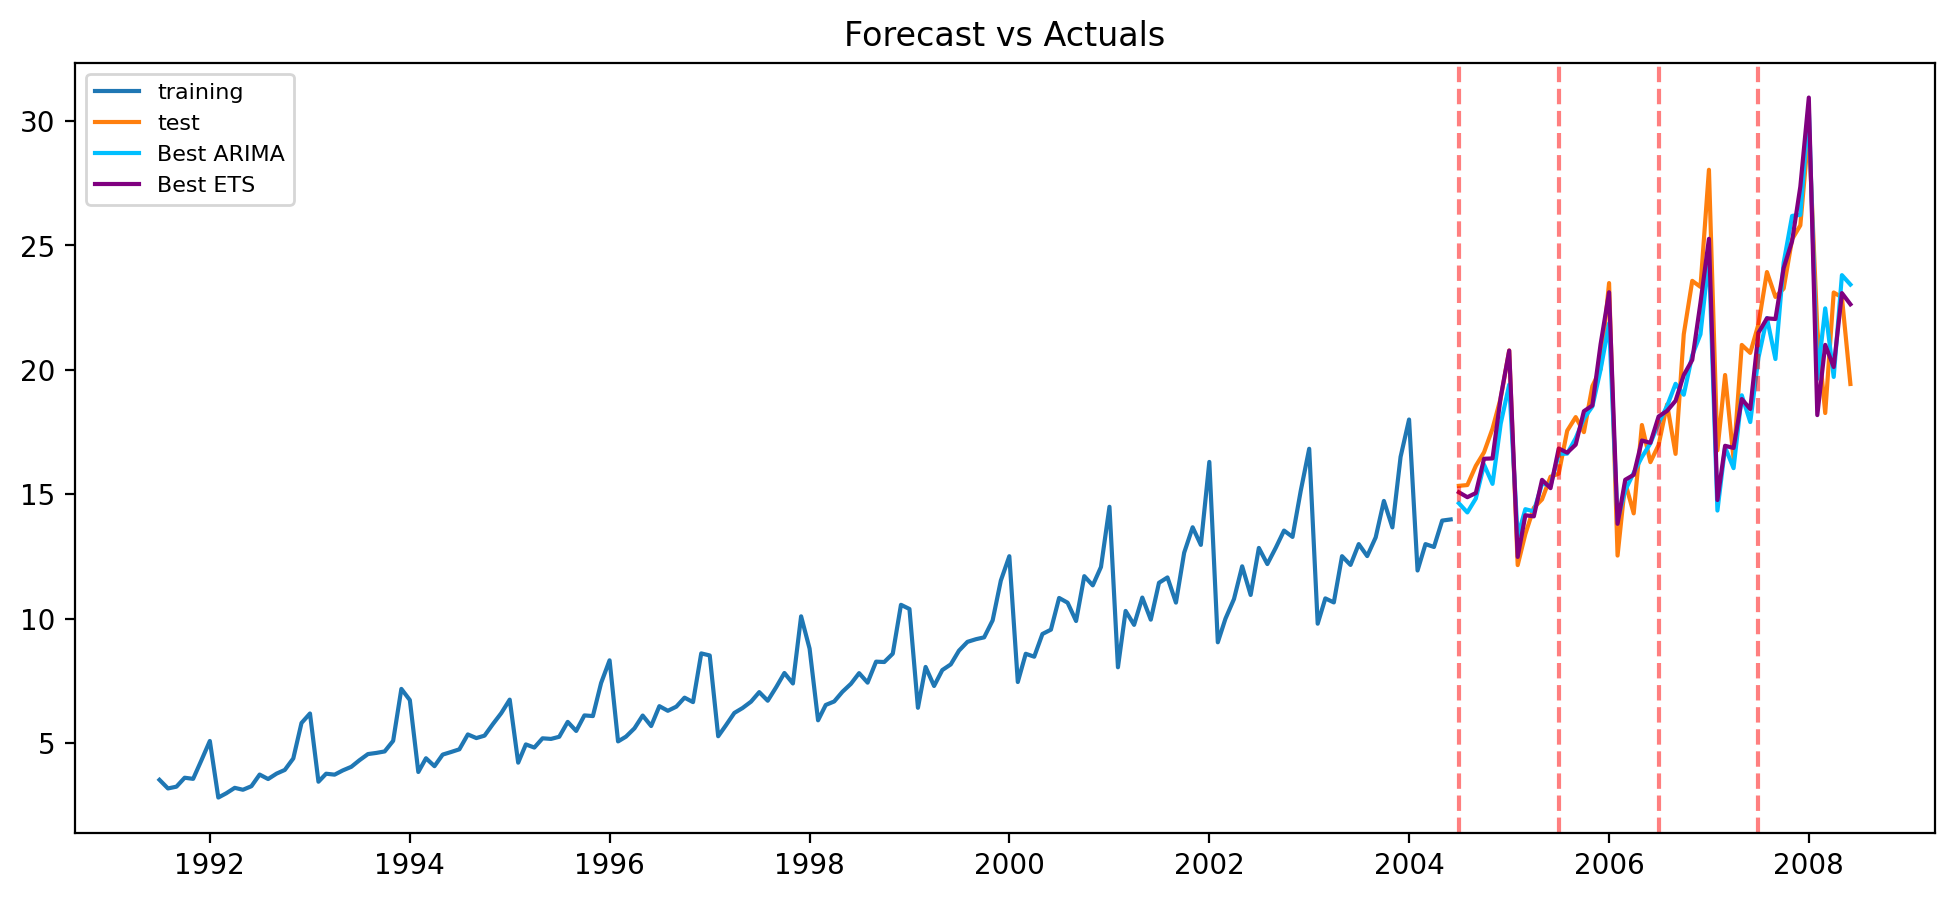

In [ ]:
# Combine Best Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(drug_sales_df.loc[:'2004-06-01'], label='training')
plt.plot(drug_sales_df.loc['2004-07-01':'2008-06-01'], label='test')

best_arima = arima_forecast_results[2]
best_ets = ets_forecast_results[-1]

test_index = drug_sales_df.loc['2004-07-01':'2008-06-01'].index

plt.plot(pd.Series(best_arima, index=test_index), label="Best ARIMA", color = 'deepskyblue')
plt.plot(pd.Series(best_ets, index=test_index), label="Best ETS", color='purple')

plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.axvline(x = pd.to_datetime('2004-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.axvline(x = pd.to_datetime('2005-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.axvline(x = pd.to_datetime('2006-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.axvline(x = pd.to_datetime('2007-07-01') , color = 'r', linestyle='--', alpha=0.5)
plt.show()

## **Conclusion**

In [ ]:
metrics_df = pd.concat([ets_backtest_result, arima_backtest_result], axis=0)
metrics_df.sort_values(by='MAE')

,RMSE,MAE,MAPE
ETS_3_mul,1.393005,1.191758,6.158462
SARIMA_2,1.695184,1.478737,7.672968
SARIMA_3,1.695277,1.481465,7.655728
SARIMA_4,1.719780,1.484232,7.695293
SARIMA_AUTO,1.717781,1.486812,7.669726
ETS_3_add,1.692975,1.487367,7.625825
SARIMA_1,1.732176,1.524059,7.863357
ARIMA_1,3.927992,3.087745,14.822366
ETS_1_0.5,4.059410,3.476356,19.676240
ETS_1_0.9,4.178206,3.595750,20.732872


Based on the backtesting results, mention which ONE model would you use to predict the next 12 months and why? \
**Based on the average 4 period backtesting results, ETS 3 with multiplicative trend and seasons give the lowest errors in terms of RMSE, MAE, and MAPE. ALso we can see that from the above plot, ets model is closer to the true curve than Arima. So I would choose it to predict the next 12 months.**
